## Flood frequency analysis
Here we apply concepts learned in the previous two notebooks (importing and exploring data) to a specific task, namely computing flood frequency at out gage site. This process involves the following sub-tasks:
* Grouping data by water year and computing annual peak flow
* Computing return intervals and probability of flood recurrences
* Computing a regression between return interval and peak flow
* Estimating peak flow from our calculated regression
* Plotting our results

In doing so, we explore the following Python concepts:
* Sorting
* Ranking
* Grouping/summarizing
* Running a regression and projecting results
* Plotting

### Importing and cleaning data
As before, we begin by importing the modules we need, then importing and preparing the data for analysis.

In [41]:
#Import modules
import pandas as pd
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [42]:
#Enable inline plots and set to use seaborn styles
%matplotlib inline
sns.set_style("whitegrid")
sns.set(font_scale=1.5)

In [43]:
#Import the streamflow data CSV, setting data types on import
df=pd.read_csv('GageData.csv',
               dtype={'site_no':'str'}, #Set 'site_no' to string obj
               parse_dates=['datetime'])#Set 'datetime' as datetime obj

In [44]:
#Add year, month, and water_year columns
df['year'] = df['datetime'].map(lambda x: x.year)
df['month'] = df['datetime'].map(lambda x: x.month)
df['water_year'] = df['datetime'].apply(lambda x: x.year if x.month < 10 else x.year + 1)

In [45]:
#Compute flow in cms
df['MeanFlow_cms'] = df['MeanFlow_cfs'] * 0.028316847 

In [46]:
#Set the index to full date
df.index = df.datetime

In [47]:
#Create data slices for pre- and post-Falls Lake
dfPre = df[:'1980-01-01']
dfPost = df['1983-12-31':]

### Compute annual peak discharge
Compute annual peak flows from our daily flow data. We do this by grouping our data on `water_year` and then computing the max daily discharge for each water year group, the results of which are stored in a new dataframe.

#### Step 1: Create a dataframe of annual peak flow
Annual peak flow is the maximum observed flow in each year, so we need to group values by year and then extract the highest observed flow from each year. The initial result is an array, but we convert it into a dataframe for easier processing afterwards.

In [48]:
#Create a "GroupBy" object, using water_year as the grouping variable
byYear = df.groupby('water_year')
#From the GroupBy object, create an array of max values for each water year
arrMaxAnnual = byYear['MeanFlow_cms'].max()
#Display the first 5 records in the array
arrMaxAnnual[:5]

water_year
1931    300.158578
1932    264.762519
1933    212.376352
1934    237.861515
1935    461.564606
Name: MeanFlow_cms, dtype: float64

In [49]:
#Convert the array to a dataframe, renaming it to PeakFlow_cms
dfPF = arrMaxAnnual.to_frame(name="PeakFlow_cms")
dfPF.head()

,PeakFlow_cms
water_year,
1931,300.158578
1932,264.762519
1933,212.376352
1934,237.861515
1935,461.564606


#### Step 2. Rank and sort data by max discharge values
Compiting return interval (RI) requires our annual data to be ranked on peak discharge. So, before we can compute RI, we need to rank our data. We'll sort them as well, for easier viewing. 

In [50]:
# Rank discharge from highest to lowest, storing value in a "rank" column
dfPF['rank'] = dfPF.rank(ascending=False)
dfPF.sort_values(by='PeakFlow_cms',ascending=False,inplace=True)
dfPF.head()

,PeakFlow_cms,rank
water_year,,
1945,637.129057,1.0
1999,557.841886,2.0
1996,535.188408,3.0
2017,532.356724,4.0
1935,461.564606,5.0


#### Step 3. Compute Return Interval (RI) and Probability of Recurrence (PoR)
Recurrence interval is computed for each year by dividing the number of records (plus 1) by the its rank. Probability of recurrence is the inverse of recurrence interval.

In [51]:
#Compute the number of records, e.g. the max of all rank values
countRecs = dfPF['rank'].max()

In [52]:
# Compute Return Interval (RI)
dfPF['RI'] = (countRecs + 1) / dfPF['rank']

In [53]:
# Compute probability of recurrence (Pe)
dfPF['Pe'] = 1 / dfPF['RI']

In [54]:
# Examine the results
dfPF.head()

,PeakFlow_cms,rank,RI,Pe
water_year,,,,
1945,637.129057,1.0,88.000000,0.011364
1999,557.841886,2.0,44.000000,0.022727
1996,535.188408,3.0,29.333333,0.034091
2017,532.356724,4.0,22.000000,0.045455
1935,461.564606,5.0,17.600000,0.056818


## Visualize the data
Have a quick look at the data to examine the likelihood of a relationship. Try a few transformations of the data...

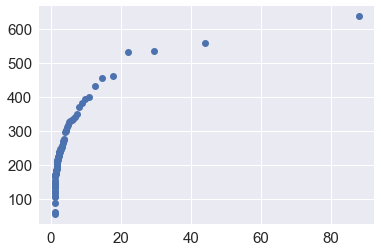

In [55]:
#Straight up plot of the data
plt.plot(dfPF['RI'],dfPF['PeakFlow_cms'],'o');

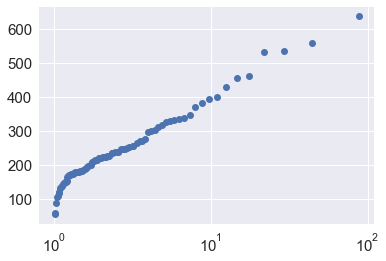

In [56]:
#Log transform the x-axis
plt.plot(dfPF['RI'],dfPF['PeakFlow_cms'],'o')
plt.xscale('log');

## Compute a regression using SciPy functions
SciPy's [`linregress`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html) function allows us to calculate linear regressions for two sets of measurements. It returns an array of 5 objects: the slope, intercept, r-value, p-value, and std. error of the model. We can use this function to quickly evaluate different transformation of our data to get the best fit trend. 

In [57]:
#Simple linear regression
x = dfPF['RI']
y = dfPF['PeakFlow_cms']
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print (r_value)

0.76042780209


In [58]:
#Linear regression, with log-transformed X
x = np.log(dfPF['RI'])
y = dfPF['PeakFlow_cms']
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print (r_value)

0.989068143448


#### Apply the equation to 100, 500, and 1000 year return intervals

In [59]:
#Create an array of years
arrYears = pd.Series([100,500,1000])
arrYears

0     100
1     500
2    1000
dtype: int64

In [60]:
#Apply the regression equations to these values
arrFlood = slope * np.log(arrYears) + intercept
arrFlood

0    671.607065
1    861.522275
2    943.314304
dtype: float64

In [61]:
#Convert to a dataframe
dfFlood = pd.concat([arrYears,arrFlood],axis=1)
dfFlood.columns = ('RI','PeakFlow_cms')
dfFlood

,RI,PeakFlow_cms
0,100,671.607065
1,500,861.522275
2,1000,943.314304


We see the R value for the log transformed is much better than the non-transformed model. Let's proceed with that. First we'll plot the data and then we'll add some additional points to our plot. 

#### Quick plot

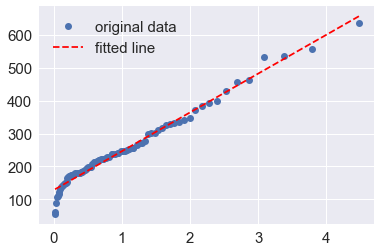

In [62]:
#A quick plot with a trendline computed from the data
plt.plot(x,y,'o',label='original data')
plt.plot(x,slope * x + intercept,'r--',label='fitted line')
plt.legend()
plt.show();

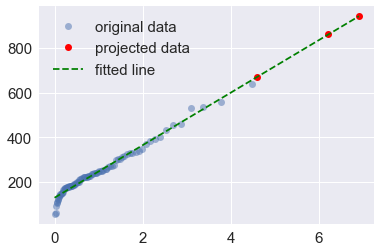

In [63]:
#Like above, but with an extended trendline and projected data
plt.plot(x,y,'o',alpha=0.5,label='original data')
plt.plot(np.log(dfFlood['RI']),dfFlood['PeakFlow_cms'],'or',label='projected data')

x1 = np.linspace(1,1000,50) #An array of 100 equal spaced values from 0 to 1000
lnX1 = np.log(x1)           #Log transform the vaues
plt.plot(lnX1,slope * lnX1 + intercept,'g--',label='fitted line')

plt.legend()
plt.show();

##### Fancier plotting
https://seaborn.pydata.org/tutorial/regression.html

https://seaborn.pydata.org/generated/seaborn.regplot.html#seaborn.regplot

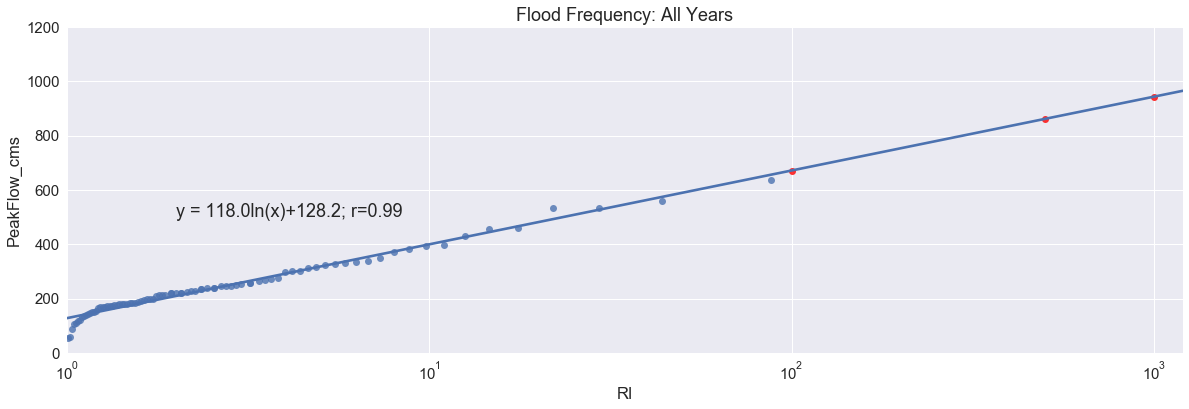

In [64]:
#Create the canvas (fig) and axes (ax) objects, setting the figure size
fig, ax = plt.subplots(figsize=(20,6))

#Set axis properties
ax.set(xlim=(1,1200),
       ylim=(0,1200),
       xscale ="log",
       label="y = ({0:0.2f}ln(x)+{1:0.2f}".format(slope,intercept)
      )

#Add the seaborn regression plot to our figure
ax = sns.regplot(x='RI',
                 y='PeakFlow_cms',
                 data=dfPF,
                 logx=True,
                 fit_reg=True,
                 ci=None,
                )

#Set the axis labels.
ax.set(xlabel='ln(Return Interval (years))', 
       ylabel='Peak discharge(cms)',
       title="Flood Frequency: All Years"
      )

ax.text(2,500,"y = {0:.1f}ln(x)+{1:.1f}; r={2:.2f}".format(slope,intercept,r_value))

ax = sns.regplot(x='RI',
                 y='PeakFlow_cms',
                 data=dfFlood,
                 logx=True,
                 fit_reg=False,
                 ci=None,
                 color="red",
                 marker='o'
                )

## ♦ Exercise: Calculate the return interval from the pre-1980 data

In [65]:
#Copy peak flow data before 1980 to a new dataframe
dfPFPre = dfPF.loc[dfPF.index < 1980].copy(deep=True)

In [66]:
#Re-rank the data
dfPFPre['rank'] = dfPFPre.rank(ascending=False)

In [67]:
#Re-compute RI & Pe
countRecs = dfPFPre['rank'].max()
dfPFPre['RI'] = (countRecs + 1) / dfPFPre['rank']
dfPFPre['Pe'] = 1/dfPFPre['RI']

In [68]:
#Re-compute the regression
x = np.log(dfPFPre['RI'])
y = dfPFPre['PeakFlow_cms']
slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(x, y)
print("y = {0:0.1f}ln(x) + {1:0.1f}; r2={2:0.2f}".format(slope1,intercept1,r_value1))

y = 109.2ln(x) + 167.6; r2=0.99


In [69]:
#Compute 100, 500, and 1000 year floods; adding to previous dfFlood dataframe
dfFlood['PreLake_cms'] = slope1 * np.log(dfFlood['RI']) + intercept1
dfFlood

,RI,PeakFlow_cms,PreLake_cms
0,100,671.607065,670.658321
1,500,861.522275,846.452510
2,1000,943.314304,922.162946


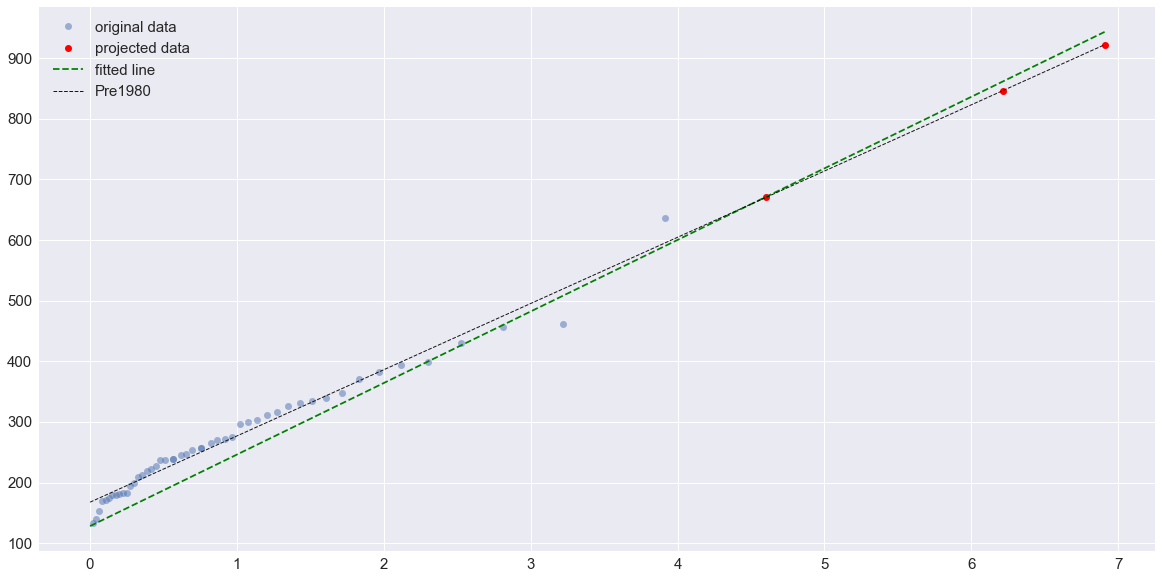

In [71]:
#Plot
plt.figure(figsize=(20,10))
plt.plot(x,y,'o',alpha=0.5,label='original data')
plt.plot(np.log(dfFlood['RI']),dfFlood['PreLake_cms'],'or',label='projected data')

x1 = np.linspace(1,1000,50) #An array of 100 equal spaced values from 0 to 1000
lnX1 = np.log(x1)           #Log transform the vaues
plt.plot(lnX1,slope * lnX1 + intercept,'g--',label='fitted line')
plt.plot(lnX1,slope1 * lnX1 + intercept1,'k--',label='Pre1980',linewidth=1,alpha=0.9)

plt.legend()
plt.show();